In [660]:
import pandas as pd
import numpy as np
import json
import folium
from datetime import datetime, timedelta
import os
import seaborn as sns
import matplotlib as plt

import yaml

In [661]:
from data_cleaning.json_manipulation import load_json, trim_json_to_locations, gather_bajs_locations, get_bikes_in_stations, calculate_bike_changes, create_changes_columns
from visualization.station_map import populate_map_with_stations
from visualization.individual_station_plots import plot_hourly_bar, plot_weekday_bar

In [662]:
config = yaml.safe_load(open("../config.YAML"))

In [663]:
with open("../data/test_JSON_data/bajs_10-11-2025_15-11-31.json") as json_data:
    day_one = json.load(json_data)
    json_data.close()

In [664]:
day_one

{'countries': [{'lat': 45.8049,
   'lng': 15.9467,
   'zoom': 10,
   'name': 'Bajs Zagreb (Croatia)',
   'hotline': '0038515494477',
   'domain': 'hd',
   'language': 'hr',
   'email': 'bajs@zagreb.hr',
   'timezone': 'Europe/Berlin',
   'currency': 'EUR',
   'country_calling_code': '+385',
   'system_operator_address': 'Sustav javnih bicikala d.o.o., Prisavlje 2, 10000 Zagreb',
   'country': 'HR',
   'country_name': 'Croatia',
   'terms': 'https://bajs.zagreb.hr/hr/uvjetikoristenja/',
   'policy': 'https://bajs.zagreb.hr/hr/pravila-privatnosti/',
   'website': 'https://bajs.zagreb.hr',
   'show_bike_types': False,
   'show_bike_type_groups': False,
   'show_free_racks': False,
   'booked_bikes': 0,
   'set_point_bikes': 2000,
   'available_bikes': 1812,
   'capped_available_bikes': False,
   'no_registration': False,
   'pricing': 'https://bajs.zagreb.hr/hr/',
   'vat': '25',
   'faq_url': 'https://bajs.zagreb.hr',
   'store_uri_android': 'https://play.google.com/store/apps/details?id

In [665]:
trim_json_to_locations(day_one)

[{'uid': 556632908,
  'lat': 45.825299,
  'lng': 16.109747,
  'bike': False,
  'name': 'AUTOBUSNI TERMINAL SESVETE',
  'address': None,
  'spot': True,
  'number': 21200,
  'booked_bikes': 0,
  'bikes': 5,
  'bikes_available_to_rent': 5,
  'active_place': 1,
  'bike_racks': 8,
  'free_racks': 3,
  'special_racks': 0,
  'free_special_racks': 0,
  'maintenance': False,
  'terminal_type': 'free',
  'bike_numbers': ['800463', '800020', '801638', '801088', '801072'],
  'bike_types': {'196': 4, '409': 1},
  'place_type': '0',
  'rack_locks': False},
 {'uid': 556633495,
  'lat': 45.842797,
  'lng': 15.975421,
  'bike': False,
  'name': 'MIHALJEVAC OKRETIŠTE',
  'address': None,
  'spot': True,
  'number': 21201,
  'booked_bikes': 0,
  'bikes': 11,
  'bikes_available_to_rent': 11,
  'active_place': 1,
  'bike_racks': 12,
  'free_racks': 1,
  'special_racks': 0,
  'free_special_racks': 0,
  'maintenance': False,
  'terminal_type': 'free',
  'bike_numbers': ['800480',
   '800247',
   '800185',
 

In [666]:
locations = gather_bajs_locations(trim_json_to_locations(day_one))
locations.head()

,uid,name,lat,lng,no_racks
0,556632908,AUTOBUSNI TERMINAL SESVETE,45.825299,16.109747,8
1,556633495,MIHALJEVAC OKRETIŠTE,45.842797,15.975421,12
2,556634009,ROTOR REMETINEC,45.776795,15.953339,10
3,556637365,ADMIRAL HOTEL,45.795083,15.919185,20
4,556689563,ZAGREBAČKI VELESAJAM,45.777560,15.969703,20


In [667]:
locations.shape
# 165 different stations in Zagreb

(165, 5)

Thunderforest.Neighbourhood
OSMBright
Esri.WorldTopoMap
CartoDB.Voyager

In [668]:
fig = folium.Figure(width = 1100, height = 500)

m = folium.Map(
    location=(45.8109, 16.0097),
    min_zoom=11,
    tiles = "Esri.WorldTopoMap"
)

fig.add_child(m)

In [669]:
m = populate_map_with_stations(m, locations)


In [670]:
m

## Individual bikes at individual times

In [671]:
first_dt = datetime.strptime("2025/11/10 15:11:31",
    "%Y/%m/%d %H:%M:%S")

first_dt

datetime.datetime(2025, 11, 10, 15, 11, 31)

In [672]:
time1 = get_bikes_in_stations(time = first_dt,
    loc_list = trim_json_to_locations(day_one))

time1.sort_values("uid").head()

,uid,time,bikes_at_station
0,556632908,2025-11-10 15:11:31,"[800463, 800020, 801638, 801088, 801072]"
1,556633495,2025-11-10 15:11:31,"[800480, 800247, 800185, 800183, 800106, 80005..."
2,556634009,2025-11-10 15:11:31,"[800220, 800201, 800129, 800079, 801644, 80155..."
3,556637365,2025-11-10 15:11:31,"[801920, 801915, 800748, 800640, 800625]"
4,556689563,2025-11-10 15:11:31,"[801846, 801835, 801548, 801542, 801000, 80099..."


In [673]:
# For testing purposes, we'll use this data as a second timepoint even though it's been more than a day
with open("../data/test_JSON_data/bajs_12-11-2025_09-30-11.json") as json_data:
    day_two = json.load(json_data)
    json_data.close()

In [674]:
second_dt = datetime.strptime("2025/11/10 16:30:00",
    "%Y/%m/%d %H:%M:%S")

time2 = get_bikes_in_stations(time = second_dt,
    loc_list = trim_json_to_locations(day_two))

time2.sort_values("uid").head()

,uid,time,bikes_at_station
0,556632908,2025-11-10 16:30:00,"[800479, 800463, 800282, 801088]"
1,556633495,2025-11-10 16:30:00,"[800480, 800185, 800052, 801489, 801321]"
2,556634009,2025-11-10 16:30:00,"[800274, 801882, 801360, 801296, 801022]"
3,556637365,2025-11-10 16:30:00,"[800344, 800033, 801920, 801915, 801881, 80164..."
4,556689563,2025-11-10 16:30:00,"[800485, 800329, 800233, 800230, 800223, 80019..."


In [675]:
more_times = pd.concat([time1, time2])
# for each uid-time, what is the closest observed time before the one in this row?
more_times["lag1_time"] = more_times.groupby(["uid"])["time"].shift(1)

more_times

previous_bikes = more_times.merge(more_times.drop(["lag1_time"], axis = 1), # so we don't get this as an additional column
    how = "left",
    left_on = ["uid", "lag1_time"],
    right_on = ["uid", "time"],
    suffixes = (None, "_lag1")).drop(
        ["time_lag1"], axis = 1
    )



previous_bikes

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1
0,556632908,2025-11-10 15:11:31,"[800463, 800020, 801638, 801088, 801072]",NaT,NaN
1,556633495,2025-11-10 15:11:31,"[800480, 800247, 800185, 800183, 800106, 80005...",NaT,NaN
2,556634009,2025-11-10 15:11:31,"[800220, 800201, 800129, 800079, 801644, 80155...",NaT,NaN
3,556637365,2025-11-10 15:11:31,"[801920, 801915, 800748, 800640, 800625]",NaT,NaN
4,556689563,2025-11-10 15:11:31,"[801846, 801835, 801548, 801542, 801000, 80099...",NaT,NaN
...,...,...,...,...,...
326,585913527,2025-11-10 16:30:00,"[800278, 800101, 801656, 801228, 801046, 80077...",2025-11-10 15:11:31,[]
327,585913605,2025-11-10 16:30:00,"[801717, 801191, 801157, 800603, 800601, 800517]",2025-11-10 15:11:31,[801963]
328,585913702,2025-11-10 16:30:00,"[800347, 800115, 801866, 801826, 801795, 80166...",2025-11-10 15:11:31,"[800293, 800219, 800191, 800068, 801907, 80175..."
329,586256300,2025-11-10 16:30:00,"[800144, 801889, 801867, 801457, 801066, 80095...",2025-11-10 15:11:31,"[800318, 800144, 801889, 801867, 801169, 80116..."


In [676]:
calculate_bike_changes(previous_bikes["bikes_at_station"], previous_bikes["bikes_at_station_lag1"])

{'changes': 0       NaN
 1       NaN
 2       NaN
 3       NaN
 4       NaN
        ... 
 326     8.0
 327     7.0
 328    31.0
 329     5.0
 330     5.0
 Length: 331, dtype: float64,
 'incoming': 0       NaN
 1       NaN
 2       NaN
 3       NaN
 4       NaN
        ... 
 326     0.0
 327     1.0
 328    15.0
 329     3.0
 330     0.0
 Length: 331, dtype: float64,
 'outgoing': 0       NaN
 1       NaN
 2       NaN
 3       NaN
 4       NaN
        ... 
 326     8.0
 327     6.0
 328    16.0
 329     2.0
 330     5.0
 Length: 331, dtype: float64}

## Load all data from folder and calculate changes

In [677]:
raw_files_directory = "../data/" + config["data"]["raw_json_folder"]

raw_files = os.listdir(raw_files_directory)
raw_files

['bajs_10-11-2025_15-11-31.json',
 'bajs_10-11-2025_21-02-43.json',
 'bajs_11-11-2025_09-06-29.json',
 'bajs_11-11-2025_21-09-35.json',
 'bajs_12-11-2025_09-02-54.json',
 'bajs_12-11-2025_09-30-11.json',
 'bajs_12-11-2025_21-07-14.json',
 'bajs_13-11-2025_09-01-27.json',
 'bajs_13-11-2025_21-12-30.json',
 'bajs_14-11-2025_09-14-47.json',
 'bajs_14-11-2025_21-09-47.json']

In [678]:
raw_files[0][5:-5]

'10-11-2025_15-11-31'

In [679]:
#TODO - extracting from first to last number instead of absolute position?

datetime.strptime(raw_files[0][5:-5], "%d-%m-%Y_%H-%M-%S")

datetime.datetime(2025, 11, 10, 15, 11, 31)

In [680]:
scraped_datetimes = [datetime.strptime(filename[5:-5], "%d-%m-%Y_%H-%M-%S") for filename in raw_files]
scraped_datetimes

[datetime.datetime(2025, 11, 10, 15, 11, 31),
 datetime.datetime(2025, 11, 10, 21, 2, 43),
 datetime.datetime(2025, 11, 11, 9, 6, 29),
 datetime.datetime(2025, 11, 11, 21, 9, 35),
 datetime.datetime(2025, 11, 12, 9, 2, 54),
 datetime.datetime(2025, 11, 12, 9, 30, 11),
 datetime.datetime(2025, 11, 12, 21, 7, 14),
 datetime.datetime(2025, 11, 13, 9, 1, 27),
 datetime.datetime(2025, 11, 13, 21, 12, 30),
 datetime.datetime(2025, 11, 14, 9, 14, 47),
 datetime.datetime(2025, 11, 14, 21, 9, 47)]

**IMPORTANT**  
The scraper times need to be adjusted up by an hour to match the local times!

In [681]:
scraped_datetimes = [date + timedelta(hours = 1) for date in scraped_datetimes]
scraped_datetimes

[datetime.datetime(2025, 11, 10, 16, 11, 31),
 datetime.datetime(2025, 11, 10, 22, 2, 43),
 datetime.datetime(2025, 11, 11, 10, 6, 29),
 datetime.datetime(2025, 11, 11, 22, 9, 35),
 datetime.datetime(2025, 11, 12, 10, 2, 54),
 datetime.datetime(2025, 11, 12, 10, 30, 11),
 datetime.datetime(2025, 11, 12, 22, 7, 14),
 datetime.datetime(2025, 11, 13, 10, 1, 27),
 datetime.datetime(2025, 11, 13, 22, 12, 30),
 datetime.datetime(2025, 11, 14, 10, 14, 47),
 datetime.datetime(2025, 11, 14, 22, 9, 47)]

In [682]:
data_timepoints = [
    trim_json_to_locations(load_json(raw_files_directory + "/" + json_file))
    for json_file
    in raw_files
]

len(data_timepoints)

11

In [683]:
bike_data = None

for i in range(len(data_timepoints)):
    timepoint_bikes = get_bikes_in_stations(time = scraped_datetimes[i],
        loc_list = data_timepoints[i])

    if i == 0: 
        bike_data = timepoint_bikes
    else:
        bike_data = pd.concat([bike_data, timepoint_bikes])

bike_data

,uid,time,bikes_at_station
0,556632908,2025-11-10 16:11:31,"[800463, 800020, 801638, 801088, 801072]"
1,556633495,2025-11-10 16:11:31,"[800480, 800247, 800185, 800183, 800106, 80005..."
2,556634009,2025-11-10 16:11:31,"[800220, 800201, 800129, 800079, 801644, 80155..."
3,556637365,2025-11-10 16:11:31,"[801920, 801915, 800748, 800640, 800625]"
4,556689563,2025-11-10 16:11:31,"[801846, 801835, 801548, 801542, 801000, 80099..."
...,...,...,...
163,585913605,2025-11-14 22:09:47,"[800420, 801796, 801587, 801486, 801278, 80113..."
164,585913702,2025-11-14 22:09:47,"[800401, 800387, 800169, 801866, 801789, 80150..."
165,586256300,2025-11-14 22:09:47,"[800452, 800144, 801889, 801867, 801122, 80106..."
166,586273004,2025-11-14 22:09:47,"[800199, 800119, 800061, 800044, 800034, 80195..."


In [684]:
bike_data = create_changes_columns(bike_data)
bike_data

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing
0,556632908,2025-11-10 16:11:31,"[800463, 800020, 801638, 801088, 801072]",NaT,NaN,NaN,NaN,NaN
1,556633495,2025-11-10 16:11:31,"[800480, 800247, 800185, 800183, 800106, 80005...",NaT,NaN,NaN,NaN,NaN
2,556634009,2025-11-10 16:11:31,"[800220, 800201, 800129, 800079, 801644, 80155...",NaT,NaN,NaN,NaN,NaN
3,556637365,2025-11-10 16:11:31,"[801920, 801915, 800748, 800640, 800625]",NaT,NaN,NaN,NaN,NaN
4,556689563,2025-11-10 16:11:31,"[801846, 801835, 801548, 801542, 801000, 80099...",NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1824,585913605,2025-11-14 22:09:47,"[800420, 801796, 801587, 801486, 801278, 80113...",2025-11-14 10:14:47,"[800395, 801796, 801792, 801555, 801486, 80127...",7.0,3.0,4.0
1825,585913702,2025-11-14 22:09:47,"[800401, 800387, 800169, 801866, 801789, 80150...",2025-11-14 10:14:47,"[800401, 800387, 800356, 800169, 801830, 80178...",6.0,3.0,3.0
1826,586256300,2025-11-14 22:09:47,"[800452, 800144, 801889, 801867, 801122, 80106...",2025-11-14 10:14:47,"[800144, 801889, 801867, 801210, 801066, 80095...",3.0,2.0,1.0
1827,586273004,2025-11-14 22:09:47,"[800199, 800119, 800061, 800044, 800034, 80195...",2025-11-14 10:14:47,"[800119, 801950, 801938, 801935, 801924, 80191...",12.0,10.0,2.0


## Total changes on map

In [685]:
# For each station, sum up all changes through time
# Also, weight changes by rack size

total_changes = bike_data.groupby("uid").sum(["changes"])
total_changes = total_changes.rename({"changes":"total_changes"}, axis = 1)
total_changes

,total_changes,incoming,outgoing
uid,,,
556632908,22.0,13.0,9.0
556633495,22.0,10.0,12.0
556634009,89.0,42.0,47.0
556637365,107.0,60.0,47.0
556689563,149.0,74.0,75.0
...,...,...,...
585913605,46.0,28.0,18.0
585913702,77.0,36.0,41.0
586256300,13.0,6.0,7.0


In [686]:
locations_changes = locations.join(total_changes, on = "uid")
locations_changes["weighted_changes"] = locations_changes["total_changes"] / locations_changes["no_racks"]
locations_changes

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
0,556632908,AUTOBUSNI TERMINAL SESVETE,45.825299,16.109747,8,22.0,13.0,9.0,2.750000
1,556633495,MIHALJEVAC OKRETIŠTE,45.842797,15.975421,12,22.0,10.0,12.0,1.833333
2,556634009,ROTOR REMETINEC,45.776795,15.953339,10,89.0,42.0,47.0,8.900000
3,556637365,ADMIRAL HOTEL,45.795083,15.919185,20,107.0,60.0,47.0,5.350000
4,556689563,ZAGREBAČKI VELESAJAM,45.777560,15.969703,20,149.0,74.0,75.0,7.450000
...,...,...,...,...,...,...,...,...,...
160,585913527,GUPČEVA ZVIJEZDA,45.827987,15.979160,10,26.0,14.0,12.0,2.600000
161,585913605,PETROVA UL. - UL. IVANA ZAJCA,45.817526,15.997421,10,46.0,28.0,18.0,4.600000
162,585913702,KORANSKA UL.,45.802365,15.968013,10,77.0,36.0,41.0,7.700000
163,586256300,GAJNICE UL. - GRINTAVEČKA UL.,45.816342,15.872686,10,13.0,6.0,7.0,1.300000


In [687]:
fig = folium.Figure(width = 1100, height = 500)

m = folium.Map(
    location=(45.8109, 16.0097),
    min_zoom=11,
    tiles = "Esri.WorldTopoMap"
)

fig.add_child(m)

In [688]:
m = populate_map_with_stations(m, 
                               locations_changes, 
                               metric_size = "total_changes", 
                               metric_tooltip_name = "Bike changes: ",
                               no_bins = 12)

In [689]:
m

We can see that the number of racks DOESN'T necessarily mean that this is the maximum amount of bikes that can be at a station at the same time. Maybe they're counted if they're in the near vicinity?  

Still, the no_racks is still useful as an approximation of how large/frequently used the station is planned to be.

### Tables of usage
Most and least used total

In [690]:
locations_changes.sort_values("total_changes",  ascending = False).head()

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
26,556723550,TRG KRALJA TOMISLAVA,45.805057,15.978300,57,512.0,283.0,229.0,8.982456
19,556702659,GREEN GOLD,45.802755,16.002169,40,360.0,166.0,194.0,9.000000
18,556702069,S.D. CVJETNO NASELJE,45.790564,15.961748,30,326.0,177.0,149.0,10.866667
58,579364165,FILOZOFSKI FAKULTET,45.796235,15.970371,20,223.0,95.0,128.0,11.150000
12,556696500,S.D. STJEPAN RADIĆ,45.784832,15.949303,20,198.0,108.0,90.0,9.900000


In [691]:
locations_changes.sort_values("total_changes",  ascending = True).head()

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
117,583385565,SD SUTINSKA VRELA,45.817745,15.832586,8,0.0,0.0,0.0,0.0
50,579361783,AUTOBUSNO STAJALIŠTE PRIGORNICA,45.815251,15.848368,10,4.0,1.0,3.0,0.4
155,585911812,RADNIČKA CESTA 228,45.778281,16.054742,10,5.0,3.0,2.0,0.5
71,579365873,PODSUSED OKRETIŠTE,45.815295,15.835378,5,6.0,3.0,3.0,1.2
48,579359701,BASEBALL CLUB ZAGREB,45.779728,15.908431,10,6.0,0.0,6.0,0.6


Most used relative to number of racks provided - possibly could use more racks installed:

In [692]:
locations_changes.sort_values("weighted_changes",  ascending = False).head()

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
87,579368895,PARK KATE ŠOLJIĆ,45.803227,15.942999,7,123.0,62.0,61.0,17.571429
119,583385717,SELSKA CESTA - UL. BLAŽA TROGIRANINA,45.791090,15.944574,10,140.0,78.0,62.0,14.000000
142,583393545,PUČKO OTVORENO UČILIŠTE,45.799511,15.970981,14,195.0,92.0,103.0,13.928571
41,573743895,PRERADOVIĆEVA UL.,45.811080,15.974207,10,138.0,58.0,80.0,13.800000
66,579365228,TC SAVICA,45.793790,15.997102,10,126.0,70.0,56.0,12.600000


## Usage by time of day

In [693]:
bike_data.head()

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing
0,556632908,2025-11-10 16:11:31,"[800463, 800020, 801638, 801088, 801072]",NaT,NaN,NaN,NaN,NaN
1,556633495,2025-11-10 16:11:31,"[800480, 800247, 800185, 800183, 800106, 80005...",NaT,NaN,NaN,NaN,NaN
2,556634009,2025-11-10 16:11:31,"[800220, 800201, 800129, 800079, 801644, 80155...",NaT,NaN,NaN,NaN,NaN
3,556637365,2025-11-10 16:11:31,"[801920, 801915, 800748, 800640, 800625]",NaT,NaN,NaN,NaN,NaN
4,556689563,2025-11-10 16:11:31,"[801846, 801835, 801548, 801542, 801000, 80099...",NaT,NaN,NaN,NaN,NaN


In [694]:
bike_data["hour"] = bike_data["time"].dt.hour
bike_data.tail()

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing,hour
1824,585913605,2025-11-14 22:09:47,"[800420, 801796, 801587, 801486, 801278, 80113...",2025-11-14 10:14:47,"[800395, 801796, 801792, 801555, 801486, 80127...",7.0,3.0,4.0,22
1825,585913702,2025-11-14 22:09:47,"[800401, 800387, 800169, 801866, 801789, 80150...",2025-11-14 10:14:47,"[800401, 800387, 800356, 800169, 801830, 80178...",6.0,3.0,3.0,22
1826,586256300,2025-11-14 22:09:47,"[800452, 800144, 801889, 801867, 801122, 80106...",2025-11-14 10:14:47,"[800144, 801889, 801867, 801210, 801066, 80095...",3.0,2.0,1.0,22
1827,586273004,2025-11-14 22:09:47,"[800199, 800119, 800061, 800044, 800034, 80195...",2025-11-14 10:14:47,"[800119, 801950, 801938, 801935, 801924, 80191...",12.0,10.0,2.0,22
1828,587422590,2025-11-14 22:09:47,[],2025-11-14 10:14:47,[],0.0,0.0,0.0,22


In [695]:
# If there is more than one row for a given station in a given hour, first sum to get totals for hour
# THEN average across days
hourly = bike_data.groupby(["uid", "time", "hour"]).sum(["changes", "incoming", "outgoing"])

hourly = hourly.groupby(["uid", "hour"]).mean(["changes", "incoming", "outgoing"])
hourly

changes  incoming  outgoing
uid       hour                             
556632908 10        1.2       0.2       1.0
          16        0.0       0.0       0.0
          22        3.2       2.4       0.8
556633495 10        0.8       0.0       0.8
          16        0.0       0.0       0.0
...                 ...       ...       ...
586273004 10        1.8       0.6       1.2
          16        0.0       0.0       0.0
          22        8.0       6.2       1.8
587422590 10        0.0       0.0       0.0
          22        0.0       0.0       0.0

[501 rows x 3 columns]

In [696]:
# Filling in missing station/hour combination with 0 changes

hours_index = pd.MultiIndex.from_product([bike_data["uid"].unique().tolist(),
    list(range(24))],
    names = ["uid", "hour"])


In [697]:
hourly = hourly.reindex(hours_index, fill_value = 0)

In [698]:
hourly

changes  incoming  outgoing
uid       hour                             
556632908 0         0.0       0.0       0.0
          1         0.0       0.0       0.0
          2         0.0       0.0       0.0
          3         0.0       0.0       0.0
          4         0.0       0.0       0.0
...                 ...       ...       ...
587422590 19        0.0       0.0       0.0
          20        0.0       0.0       0.0
          21        0.0       0.0       0.0
          22        0.0       0.0       0.0
          23        0.0       0.0       0.0

[4032 rows x 3 columns]

In [699]:
# plots for one station

# trg kralja tomislava
station = 556723550

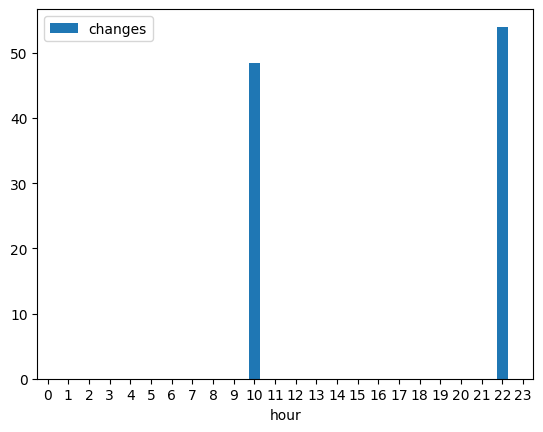

In [700]:
_ = plot_hourly_bar(hourly.loc[station], changes_type = "total")

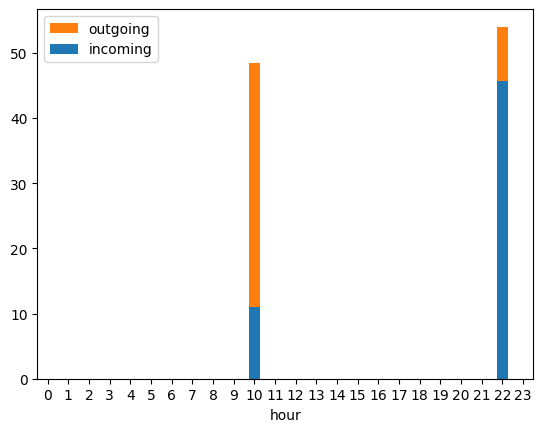

In [701]:
_ = plot_hourly_bar(hourly.loc[station], changes_type = "in/out")

## Usage by day of week

In [702]:
bike_data["wday"] = bike_data["time"].dt.weekday
bike_data.tail()

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing,hour,wday
1824,585913605,2025-11-14 22:09:47,"[800420, 801796, 801587, 801486, 801278, 80113...",2025-11-14 10:14:47,"[800395, 801796, 801792, 801555, 801486, 80127...",7.0,3.0,4.0,22,4
1825,585913702,2025-11-14 22:09:47,"[800401, 800387, 800169, 801866, 801789, 80150...",2025-11-14 10:14:47,"[800401, 800387, 800356, 800169, 801830, 80178...",6.0,3.0,3.0,22,4
1826,586256300,2025-11-14 22:09:47,"[800452, 800144, 801889, 801867, 801122, 80106...",2025-11-14 10:14:47,"[800144, 801889, 801867, 801210, 801066, 80095...",3.0,2.0,1.0,22,4
1827,586273004,2025-11-14 22:09:47,"[800199, 800119, 800061, 800044, 800034, 80195...",2025-11-14 10:14:47,"[800119, 801950, 801938, 801935, 801924, 80191...",12.0,10.0,2.0,22,4
1828,587422590,2025-11-14 22:09:47,[],2025-11-14 10:14:47,[],0.0,0.0,0.0,22,4


In [703]:
# Sum up for whole day
# THEN average across days
daily = bike_data.groupby(["uid", "time", "wday"]).sum(["changes", "incoming", "outgoing"]).drop(["hour"], axis = 1)

daily = daily.groupby(["uid", "wday"]).mean(["changes", "incoming", "outgoing"])
daily

changes  incoming  outgoing
uid       wday                              
556632908 0     1.000000  0.500000  0.500000
          1     2.500000  1.500000  1.000000
          2     1.333333  0.666667  0.666667
          3     2.500000  1.000000  1.500000
          4     3.000000  2.500000  0.500000
...                  ...       ...       ...
586273004 1     3.500000  3.000000  0.500000
          2     3.000000  1.333333  1.666667
          3     8.500000  5.500000  3.000000
          4     7.000000  5.500000  1.500000
587422590 4     0.000000  0.000000  0.000000

[832 rows x 3 columns]

In [704]:
# Filling in missing station/day combination with 0 changes

days_index = pd.MultiIndex.from_product([bike_data["uid"].unique().tolist(),
    list(range(7))],
    names = ["uid", "wday"])


In [705]:
daily = daily.reindex(days_index, fill_value = 0)

In [706]:
daily

changes  incoming  outgoing
uid       wday                              
556632908 0     1.000000  0.500000  0.500000
          1     2.500000  1.500000  1.000000
          2     1.333333  0.666667  0.666667
          3     2.500000  1.000000  1.500000
          4     3.000000  2.500000  0.500000
...                  ...       ...       ...
587422590 2     0.000000  0.000000  0.000000
          3     0.000000  0.000000  0.000000
          4     0.000000  0.000000  0.000000
          5     0.000000  0.000000  0.000000
          6     0.000000  0.000000  0.000000

[1176 rows x 3 columns]

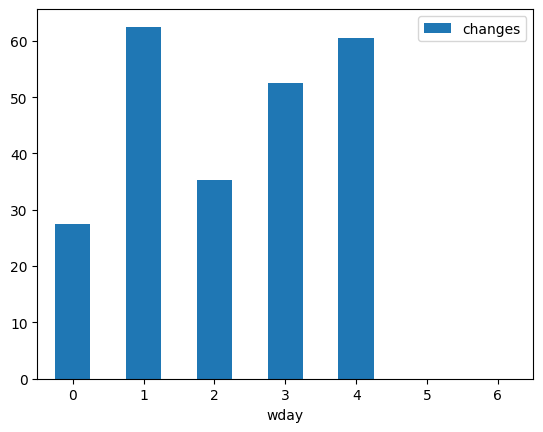

In [707]:
_ = plot_weekday_bar(daily.loc[station], changes_type = "total")

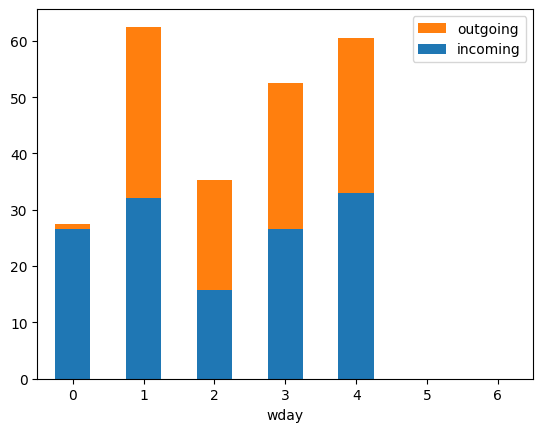

In [708]:
_ = plot_weekday_bar(daily.loc[station], changes_type = "in/out")